In [1]:
# Library for linear algebra
import numpy as np
from numpy import linalg
from numpy import random
# Library and functions for the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
# Library for precompiled (and faster) code
import numba as numba
from numba import njit
# Linrary for optimization
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

In [2]:
# Parameters of the potentials
x0=1.0
a0=1.0/3.0
b0=5.0/3.0
u0=5.0
w0=1.0/5.0

@njit(fastmath=True)
def potential(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    U = u0*(np.exp(-(q[0]**2 + q[1]**2)) - 3.0/5.0*np.exp(-(q[0]**2 + (q[1] - b0)**2)) - np.exp(-((q[0]-x0)**2+q[1]**2)) - np.exp(-((q[0]+x0)**2 + q[1]**2))) + w0*(q[0]**4 + (q[1] - a0)**4)
    return U

@njit(fastmath=True)
def force(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    x2 = q[0]**2  # Square of x coordinate
    y2 = q[1]**2  # Square of y coordinate
    # Exponentials to speed up code
    e1 = np.exp(-(x2 + y2))
    e2 = np.exp(-(x2+(q[1]- b0)**2))
    e3 = np.exp(-((q[0] - x0)**2 + y2))
    e4 = np.exp(-((q[0] + x0)**2 + y2))
    # Components of the force
    fx = 2*u0*(q[0]*e1 -3.0/5.0*q[0]*e2 - (q[0]-x0)*e3 - (q[0]+x0)*e4)-4.0*w0*q[0]**3
    fy = 2*u0*(q[1]*e1 -3.0/5.0*(q[1] - b0)*e2 - q[1]*e3 - q[1]*e4)-4.0*w0*(q[1] - a0)**3
    return np.array([fx, fy])

R = 0.6

#@njit(fastmath=True)
#def state(q, R=0.3): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
#    state = 0  # Transition state
#    tmp1 = q[0]**2 + 1.15**2 + q[1]**2
#    tmp2 = 2.0*1.15*q[0]
#    if tmp1 - tmp2 < R**2:
#        U = potential(q)
#        if U <-2.4:  # Product state
#            state = 1
#    if tmp1 + tmp2 < R**2:
#        U = potential(q)
#        if U <-2.4:  # Reactant state
#            state = -1
#    return state

@njit(fastmath=True)
def state(q): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    state = 0  # Transition state
    tmp1 = q[0]**2 + 1.15**2 + q[1]**2
    tmp2 = 2.0*1.15*q[0]
    if tmp1 - tmp2 < R**2:
        # Product state
        state = 1
    if tmp1 + tmp2 < R**2:
        # Reactant state
        state = -1
    return state

In [3]:
@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

In [4]:
## First guess of the committor function: q increases linearly along x
# The committor starts from the inner edges of the states
@njit(fastmath=True)
def qLin(q):
    if q[0] <= R-1.15:
        return 0
    elif q[0] >= 1.15-R:
        return 1
    else:
        return q[0]/(2.0*(1.15-R))+0.5

#Gradient of the first committor guess
@njit(fastmath=True)
def dqLin(q):
    if q[0] < R-1.15 or q[0] > 1.15-R:
        return 0.0, 0.0
    else:
        return 1.0/(2.0*(1.15-R)), 0.0
    
#Second guess of the committor function: q increases along a circle
@njit(fastmath=True)
def qCircle(q):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else: 
        return (theta - alpha)/(np.pi - alpha)

#Gradient of the second committor guess
@njit(fastmath=True)
def dqCircle(q):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1]>0:
            return q[1]/(q[0]**2 + q[1]**2)/(np.pi - alpha), -q[0]/(q[0]**2 + q[1]**2)/(np.pi - alpha)
        else:
            return -q[1]/(q[0]**2 + q[1]**2)/(np.pi - alpha), q[0]/(q[0]**2 + q[1]**2)/(np.pi - alpha)
        
        
@njit(fastmath=True)
def qCircleU(q):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else:
        if q[1] < 0.0:
            return 0.0
        else:
            return (theta - alpha)/(np.pi - alpha)

@njit(fastmath=True)
def dqCircleU(q):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1] > 0.0:
            return q[1]/(q[0]**2 + q[1]**2)/(np.pi - alpha), -q[0]/(q[0]**2 + q[1]**2)/(np.pi - alpha)
        else:
            return 0.0, 0.0            
                
@njit(fastmath=True)
def qCircleD(q):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else:
        if q[1] > 0.0:
            return 0.0
        else:
            return (theta - alpha)/(np.pi - alpha)   
        
@njit(fastmath=True)
def dqCircleD(q):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1]< 0.0:
            return -q[1]/(q[0]**2 + q[1]**2)/(np.pi - alpha), q[0]/(q[0]**2 + q[1]**2)/(np.pi - alpha)
        else:
            return 0.0, 0.0
        
# Third guess function: euclidian distance between the two states
@njit(fastmath=True)
def qDist(q):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 1.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15-R)**2:
        return 0.0
    else:
        return 1.0-(np.sqrt((q[0] - 1.15)**2 + q[1]**2)-R)/(2.0*(1.15-R))
        
@njit(fastmath=True)        
def dqDist(q):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15+R)**2:
        return 0.0, 0.0
    else:
        return -(q[0] - 1.15)/(2.0*(1.15-R)*np.sqrt((q[0] - 1.15)**2 + q[1]**2)), -q[1]/(2.0*(1.15-R)*np.sqrt((q[0] - 1.15)**2 + q[1]**2))

In [5]:
@njit(fastmath=True)
def ListGuess(n, q):
    if n == 0:
        return qLin(q)
    elif n == 1:
        return qCircleU(q)
    else:
        return qDist(q)
    
@njit(fastmath=True)
def ListdGuess(n, q):
    if n == 0:
        return dqLin(q)
    elif n == 1:
        return dqCircleU(q)
    else:
        return dqDist(q)

In [6]:
@njit(fastmath=True)
def LI_RMDN(c, q0 = None, dt = 0.02, KbT = 0.5, kr = 300, seed=None, isteps = 4000):
    ## Number of committor functions given as input
    n = len(c)
    
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps, n, n), dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    dGy = np.empty(n, dtype=np.float64)
    # Assign initial position to the border of the reactant state
    if q0 is None:
        r = random.random_sample()
        q[0,0] = -1.15+R*r+0.001
        q[0,1] = R*np.sqrt(1.0-r**2)+0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])
        # Evaluate z
        z = 0.0
        for k in range(n):
            z += c[k]*ListGuess(k, q[i,:])
        # Gradient components of the committors
        for k in range(n):
            dGx[k], dGy[k] = ListdGuess(k, q[i,:])  
        # Evaluating M Matrix
        for k in range(n):
            for l in range(n):
                M[i,k,l] = dGx[k]*dGx[l]+dGy[k]*dGy[l]
        # Dynamics
        if z > zmax:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            ratchetx = 0.0
            ratchety = 0.0
            for k in range(n):
                ratchetx += c[k]*dGx[k]
                ratchety += c[k]*dGy[k]
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)+kr*ratchetx*(zmax - z)*dt
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)+kr*ratchety*(zmax - z)*dt
        i += 1
        s = state(q[i,:])
    
    M *= np.sqrt(2.0*KbT)
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, n, n), dtype=np.float64)
        for k in range(n):
            for l in range(n):
                outM[i,k,l] = 0.0
        return out, outM
        
    return q[j+1:i-1,:], M[j+1:i-1,:,:]

@njit(fastmath=True)
def LIM(q0, dt = 0.02, KbT = 0.5, seed=None, isteps = 100000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q_trans = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps, n, n), dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    dGy = np.empty(n, dtype=np.float64)
    # Initial conditions
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    # Index for the transition trajectory
    j = 0
    for i in range(isteps-1):
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
        if state(q[i+1,:]) == 0:
            # Gradient components of the committors
            for k in range(n):
                dGx[k], dGy[k] = ListdGuess(k, q[i+1,:])  
            # Evaluating M Matrix
            for k in range(n):
                for l in range(n):
                    M[j,k,l] = dGx[k]*dGx[l]+dGy[k]*dGy[l]
            q_trans[j,:] = q[i+1,:]
            j+=1
            
    if j == 0:
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        Mout = np.empty((1, n, n), dtype=np.float64)
        Mout[0,0,0] = 0.0
        Mout[0,0,1] = 0.0
        Mout[0,1,0] = 0.0
        Mout[0,1,1] = 0.0
        return out, Mout
    
    else:
        return q_trans[:j,:], M[:j,:,:]

def Boltz_sample(c, base_seed, dt = 0.02, KbT = 0.5, kr = 300, isteps = 4000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj0, M = LI_RMDN(c = c, dt=dt, KbT = KBT,kr=kr,isteps=isteps)
        if traj0[0,0] != 0.0 and traj0[0,1] != 0.0:
            q0 = traj0[1::5,:]
            for i in range(q0.shape[0]):
                traj, M = LIM(q0[i,:], KbT = KBT,isteps = 10)  # I run the integrator
                if traj[0,0] != 0 and traj[0,1] != 0:
                    if tmp==0:
                        Mall = np.copy(M)
                        tmp = 1
                    if tmp==1:
                        Mall = np.concatenate((Mall, M), axis=0)
                del traj, M
        del traj0
    
    D = np.sqrt(2.0*KBT)
    M = np.zeros((n,n), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(n):
            for j in range(n):
                M[i,j] += Mall[k,i,j]

    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    M *= D

    # Matrices used for the minimization procedure
    A = [1.0 for i in range(n)]
    B = [0.0 for i in range(n)]
    # Minimization procedure
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,constraints=LinearConstraint(A, 1.0, 1.0),options={'verbose': 0}, bounds=Bounds(B, A))
    
    return np.array(cout.x)

def Self_consistent(c,  dt = 0.02, KbT = 0.5, kr = 300, isteps = 4000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    n = len(c)
    cout = np.empty((ksteps, n), dtype=np.float64)
    for i in range(n):
        cout[0,i] = c[i]
    
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample(c = c, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample(c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [7]:
# Parameters of the run
KBT = 0.5
KR = 300
n = 3

In [8]:
ksteps=30
alpha=0.5
dt = 0.02
for gigi in range(100):
    c = [1.0/n for i in range(n)]
    cout = np.empty((ksteps, n), dtype=np.float64)
    for i in range(n):
        cout[0,i] = c[i]
    
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    # Sampling of transition region
    tmp1 = 0
    for j in range(1000):  
        # Define preliminary variables
        q = np.empty((4000, 2), dtype=np.float64)
        M = np.empty((4000, n, n), dtype=np.float64)
        dGx = np.empty(n, dtype=np.float64)
        dGy = np.empty(n, dtype=np.float64)
        # Assign initial position to the border of the reactant state
        r = random.random_sample()
        q[0,0] = -1.15+R*r+0.001
        q[0,1] = R*np.sqrt(1.0-r**2)+0.001
        i = 0
        l = 0
        tmp2 = 0
        s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
        zmax = 0.0
        # Diffusion coefficient
        D = np.sqrt(2.0*KBT*dt)
        while i < 4000 - 1 and tmp2 == 0:
            if s == -1:
                # Restart trajectory
                l = i
            elif s == 1:
                #Exit from loop
                tmp2 = 1 
            # Evaluate evolution of the system
            f = force(q[i,:])
            # Evaluate z
            z = 0.0
            for k in range(n):
                z += cout[0,k]*ListGuess(k, q[i,:])
            # Gradient components of the committors
            for k in range(n):
                dGx[k], dGy[k] = ListdGuess(k, q[i,:])  
            # Evaluating M Matrix
            for k in range(n):
                for l in range(n):
                    M[i,k,l] = dGx[k]*dGx[l]+dGy[k]*dGy[l]
            # Dynamics
            if z > zmax:
                q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
                q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
                zmax = z
            else:
                ratchetx = 0.0
                ratchety = 0.0
                for k in range(n):
                    ratchetx += cout[0,k]*dGx[k]
                    ratchety += cout[0,k]*dGy[k]
                q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)+KR*ratchetx*(zmax - z)*dt
                q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)+KR*ratchety*(zmax - z)*dt
            i += 1
            s = state(q[i,:])
    
        M *= np.sqrt(2.0*KBT)
    
        # Output in the case we do not find a reactive coordinate, so that the function does not crash
        if tmp2 == 0:
            print('No reactive trajectory found!')
            out = np.empty((1, 2), dtype=np.float64)
            out[0,0] = 0.0
            out[0,1] = 0.0
            outM = np.empty((1, n, n), dtype=np.float64)
            for k in range(n):
                for l in range(n):
                    outM[i,k,l] = 0.0
            traj0 = out
            M = outM
        
        traj0 = q[l+1:i-1,:]
        M = M[l+1:i-1,:,:]
        
        if traj0[0,0] != 0.0 and traj0[0,1] != 0.0:
            q0 = traj0[1::5,:]
            for p in range(q0.shape[0]):
                traj, M = LIM(q0[p,:], KbT = KBT,isteps = 10)  # I run the integrator
                if traj[0,0] != 0 and traj[0,1] != 0:
                    if tmp1==0:
                        Mall = np.copy(M)
                        tmp = 1
                    if tmp1==1:
                        Mall = np.concatenate((Mall, M), axis=0)
                del traj, M
        del traj0
    
    D = np.sqrt(2.0*KBT)
    M = np.zeros((n,n), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(n):
            for j in range(n):
                M[i,j] += Mall[k,i,j]

    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    M *= D

    # Matrices used for the minimization procedure
    A = [1.0 for i in range(n)]
    B = [0.0 for i in range(n)]
                                 
    # Minimization procedure
    ctmp = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,constraints=LinearConstraint(A, 1.0, 1.0),options={'verbose': 0}, bounds=Bounds(B, A))
    cout[1,:] = ctmp.x       
    
    # I iterate the previous procedure many times
    for m in range(ksteps - 2):
        print("Cycle = ", m + 3)
    
        tmp1 = 0
        for j in range(1000):
            traj0, M = LI_RMDN(c = alpha*cout[m+1,:] + (1.0 - alpha)*cout[m,:], KbT = KBT,kr=KR)
            
            # Define preliminary variables
            q = np.empty((4000, 2), dtype=np.float64)
            M = np.empty((4000, n, n), dtype=np.float64)
            dGx = np.empty(n, dtype=np.float64)
            dGy = np.empty(n, dtype=np.float64)
            # Assign initial position to the border of the reactant state
            r = random.random_sample()
            q[0,0] = -1.15+R*r+0.001
            q[0,1] = R*np.sqrt(1.0-r**2)+0.001
            i = 0
            l = 0
            tmp2 = 0
            s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
            zmax = 0.0
            # Diffusion coefficient
            D = np.sqrt(2.0*KBT*dt)
            while i < 4000 - 1 and tmp2 == 0:
                if s == -1:
                    # Restart trajectory
                    l = i
                elif s == 1:
                    #Exit from loop
                    tmp2 = 1 
                # Evaluate evolution of the system
                f = force(q[i,:])
                # Evaluate z
                z = 0.0
                for k in range(n):
                    z += (alpha*cout[m+1,k] + (1.0 - alpha)*cout[m,k])*ListGuess(k, q[i,:])
                # Gradient components of the committors
                for k in range(n):
                    dGx[k], dGy[k] = ListdGuess(k, q[i,:])  
                # Evaluating M Matrix
                for k in range(n):
                    for l in range(n):
                        M[i,k,l] = dGx[k]*dGx[l]+dGy[k]*dGy[l]
                # Dynamics
                if z > zmax:
                    q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
                    q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
                    zmax = z
                else:
                    ratchetx = 0.0
                    ratchety = 0.0
                    for k in range(n):
                        ratchetx += (alpha*cout[m+1,k] + (1.0 - alpha)*cout[m,k])*dGx[k]
                        ratchety += (alpha*cout[m+1,k] + (1.0 - alpha)*cout[m,k])*dGy[k]
                    q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)+KR*ratchetx*(zmax - z)*dt
                    q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)+KR*ratchety*(zmax - z)*dt
                i += 1
                s = state(q[i,:])
        
            M *= np.sqrt(2.0*KBT)
    
            # Output in the case we do not find a reactive coordinate, so that the function does not crash
            if tmp2 == 0:
                print('No reactive trajectory found!')
                out = np.empty((1, 2), dtype=np.float64)
                out[0,0] = 0.0
                out[0,1] = 0.0
                outM = np.empty((1, n, n), dtype=np.float64)
                for k in range(n):
                    for l in range(n):
                        outM[i,k,l] = 0.0
                traj0 = out
                M = outM
            
            traj0 = q[l+1:i-1,:]
            M = M[l+1:i-1,:,:]
            
            if traj0[0,0] != 0.0 and traj0[0,1] != 0.0:
                q0 = traj0[1::5,:]
                for p in range(q0.shape[0]):
                    traj, M = LIM(q0[p,:], KbT = KBT,isteps = 10)  # I run the integrator
                    if traj[0,0] != 0 and traj[0,1] != 0:
                        if tmp1==0:
                            Mall = np.copy(M)
                            tmp = 1
                        if tmp1==1:
                            Mall = np.concatenate((Mall, M), axis=0)
                    del traj, M
            del traj0
    
        D = np.sqrt(2.0*KBT)
        M = np.zeros((n,n), dtype=np.float64)
        # Average all the values of M
        for k in range(Mall.shape[0]):
            for i in range(n):
                for j in range(n):
                    M[i,j] += Mall[k,i,j]

        # Average M over all the values obtained with the sampling
        M /= Mall.shape[0]
        M *= D

        # Matrices used for the minimization procedure
        A = [1.0 for i in range(n)]
        B = [0.0 for i in range(n)]
                                 
        # Minimization procedure
        ctmp = minimize(I, alpha*cout[m+1,:] + (1.0 - alpha)*cout[m,:], M, method='trust-constr', jac=I_der, hess=I_hess,constraints=LinearConstraint(A, 1.0, 1.0),options={'verbose': 0}, bounds=Bounds(B, A))
        cout[m+2,:] = ctmp.x   

Cycle =  1
Cycle =  2
Cycle =  3


/home/francesco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: RuntimeWarning: invalid value encountered in multiply


Cycle =  4
Cycle =  5
Cycle =  6
Cycle =  7
Cycle =  8
Cycle =  9
Cycle =  10
Cycle =  11
Cycle =  12
Cycle =  13
Cycle =  14
Cycle =  15
Cycle =  16
Cycle =  17
Cycle =  18
Cycle =  19
Cycle =  20
Cycle =  21
Cycle =  22
Cycle =  23
Cycle =  24
Cycle =  25
Cycle =  26
Cycle =  27
Cycle =  28
Cycle =  29
Cycle =  30
Cycle =  1
Cycle =  2
Cycle =  3
Cycle =  4
Cycle =  5
Cycle =  6
Cycle =  7
Cycle =  8
Cycle =  9
Cycle =  10
Cycle =  11
Cycle =  12
Cycle =  13
Cycle =  14
Cycle =  15
Cycle =  16


ZeroDivisionError: division by zero

In [10]:
print(k,m)

1 13


In [42]:
i = 456
print(q[i,:])
print(q[i,0]**2 + q[i,1]**2)

[-0.30750499  0.13844668]
0.1137268010552569


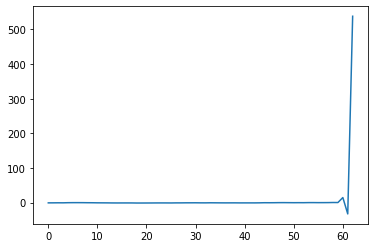

In [34]:
plt.figure
plt.plot(q[400:463,0])
plt.show()

In [24]:
plt.figure
plt.plot(q[:500,1])
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'logplot'